<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Anomaly_Sound_Detection_MobileNet_Stratified_One_Hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[機械稼働音の異常検知](https://signate.jp/competitions/358)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint_path = "./cp.ckpt"

## Unpack Zip file in which Melspectram images are.

In [ ]:
import os
import shutil
if os.path.isdir('./train_img'):
  shutil.rmtree('./train_img')
if os.path.isdir('./test_img'):
  shutil.rmtree('./test_img')

In [ ]:
!cp "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/01_input.zip" .

In [ ]:
import shutil
shutil.unpack_archive('/content/01_input.zip', '.')

## Import modules

In [ ]:
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Reading CSV

In [ ]:
df = pd.read_csv("./train.csv")
df["status"] = df["status"].astype(str)
display(df)

,image,status
0,valid_normal_018.png,0
1,valid_normal_024.png,0
2,valid_normal_030.png,0
3,train_normal_210.png,0
4,train_normal_204.png,0
...,...,...
495,valid_anomaly_030.png,1
496,valid_anomaly_026.png,1
497,valid_anomaly_032.png,1
498,valid_anomaly_033.png,1


## CNN Model

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_DEPTH = 3

BATCH_SIZE = 32
train_dir = './train_img/'

In [ ]:
lr:float = 0.001 # Default:0.001

base_model = applications.mobilenet.MobileNet(weights='imagenet',
                                        include_top=False,
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
                                      )

model = models.Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer = adam_low_rate,
              loss = "binary_crossentropy",
              metrics = ['accuracy']
            )

<ipython-input-9-6b4673f09ced>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.mobilenet.MobileNet(weights='imagenet',


## Generating Image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                              rescale=1./255, # 255で割ることで正規化
                              zoom_range=0.2, # ランダムにズーム
                              horizontal_flip = True, # 水平反転
                              height_shift_range=0.1,
                            )
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
TEST_DIR = "./test_img/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(IMG_WIDTH,IMG_HEIGHT), class_mode=None, shuffle=False)

Found 200 images belonging to 1 classes.


Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8508 - loss: 13.1412 - val_accuracy: 0.9000 - val_loss: 9.6028
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8661 - loss: 1.1819 - val_accuracy: 0.9000 - val_loss: 4.3279
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8965 - loss: 0.2867 - val_accuracy: 0.9000 - val_loss: 4.5628
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9005 - loss: 0.2656 - val_accuracy: 0.9000 - val_loss: 8.1725
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9379 - loss: 0.2158 - val_accuracy: 0.9000 - val_loss: 4.4462
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9417 - loss: 0.1389 - val_accuracy: 0.9000 - val_loss: 4.5475
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9913 - loss: 0.0394 - val_accuracy: 0.9000 - val_loss: 11.3213
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9494 - loss: 0.0959 - val_accuracy: 0.9000 - val_loss: 4.0572
E

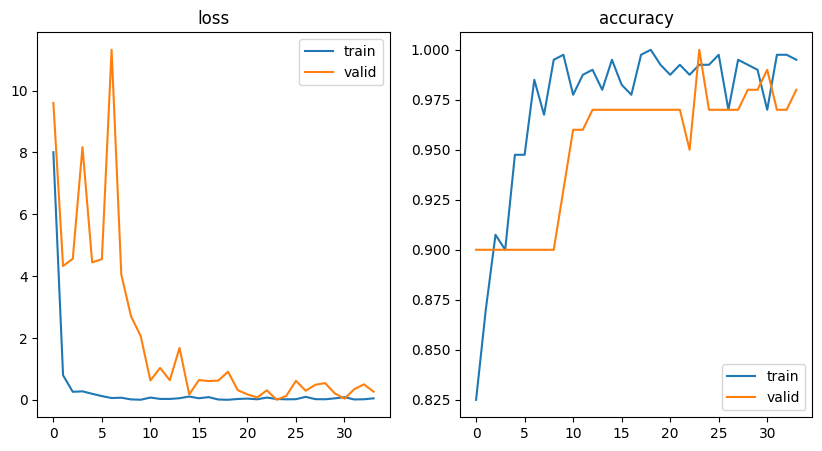

In [ ]:
epochs:int = 50 # Defalut:50

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['status'], random_state=42)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = 'image',
                                                    y_col = 'status',
                                                    directory = train_dir,
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    shuffle = True,
                                                  )

valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                    x_col = 'image',
                                                    y_col = 'status',
                                                    directory = train_dir,
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    shuffle = True,
                                                  )

history = model.fit(train_generator,
                    validation_data = valid_generator,
                    verbose=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
)

# 評価する。
test_loss, test_acc = model.evaluate(valid_generator)

model.save('model.h5')

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

plt.savefig("./metrics.png")

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

valid = model.predict(valid_generator, valid_generator.samples)
valid = np.argmax(valid, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, valid))
print('Classification Report')
print(classification_report(valid_generator.classes, valid, target_names=None))

13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Confusion Matrix
[[360   0]
 [ 40   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       360
           1       0.00      0.00      0.00        40

    accuracy                           0.90       400
   macro avg       0.45      0.50      0.47       400
weighted avg       0.81      0.90      0.85       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## To Output Submitting CSV

In [ ]:
ans = pd.read_csv("/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/sample_submit.csv",  header=None)

In [ ]:
pred = model.predict(test_generator)
pred = np.where(pred < 0.5, 0, 1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [ ]:
ans[1] = pred
ans.to_csv(path_or_buf = "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/submission_.csv", index=False, header=None)

In [ ]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,1
